Dataset can be found here: https://www.kaggle.com/gruntoff/untappd-checkins

# Importing libraries

In [ ]:
!pip install category_encoders==2.*

     |████████████████████████████████| 82 kB 198 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
datapath = 'checkins.csv'

# Wrangle Function

In [ ]:
def wrangle(datapath):
  df = pd.read_csv(datapath,
                   parse_dates=['created_at'],
                   index_col='created_at')
  #Drop columns with one value
  columns = ['user_id', 'user_name', 'source_app']
  df.drop(columns=columns, inplace=True)

  #Dropping HCCs
  cutoff = 200
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  #Correcting cities with different spellings
  minsk = ['Мінск', 'Минск', 'Минский р-н']
  moscow = ['Moskva', 'Москва']
  vitebsk = ['Віцебск', 'Витебск']
  tallinn = ['Tallinn', 'Tallinna linn', 'Põhja-Tallinna']
  df['venue_city'] = df['venue_city'].replace(minsk, 'Minsk').replace(moscow, 'Moscow').replace(vitebsk, 'Vitebsk').replace(tallinn, 'Tallinn')

  #Removing ID Columns
  id_columns = ['beer_id', 'brewery_id', 'venue_id', 'checkin_id']
  df.drop(columns=id_columns, inplace=True)

  #Creating binary classification column
  high_rating = []
  for rating in df['rating_score']:
    if rating >= 4.0:
      high_rating.append(1)
    else:
      high_rating.append(0)
  df['high_rating'] = high_rating

  #Dropping avg_rating column
  df.drop(columns=['avg_rating'], inplace=True)
  
  return df

In [ ]:
untappd = wrangle(datapath)

In [ ]:
untappd.head()

,rating_score,beer_style,beer_abv,brewery_type,brewery_country,toasts_count,venue_country,venue_city,venue_lat,venue_lng,ratings_count,checkins_count,high_rating
created_at,,,,,,,,,,,,,
2020-12-08 19:09:24+00:00,3.50,IPA - Session / India Session Ale,4.5,Macro Brewery,Spain,0,Беларусь,Minsk,53.8609,27.57,8755.0,10789.0,0
2020-12-06 21:49:46+00:00,3.50,Pale Ale - American,5.5,Micro Brewery,Russia,0,Беларусь,Minsk,53.8609,27.57,3078.0,3960.0,0
2020-12-06 21:48:07+00:00,0.00,Pale Ale - American,6.0,Home Brewery,Belarus,1,Беларусь,Minsk,53.8609,27.57,0.0,1.0,0
2020-12-05 23:04:03+00:00,4.00,IPA - Triple New England,10.0,Nano Brewery,Belarus,2,Беларусь,Minsk,53.8609,27.57,71.0,93.0,1
2020-12-05 20:51:22+00:00,3.75,Fruit Beer,4.0,Micro Brewery,Russia,1,Беларусь,Minsk,53.8609,27.57,486.0,543.0,0


# EDA

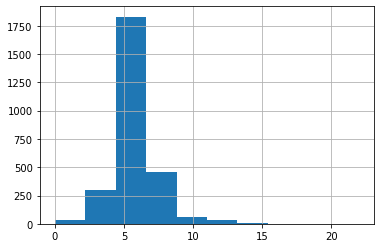

In [ ]:
untappd['beer_abv'].hist()

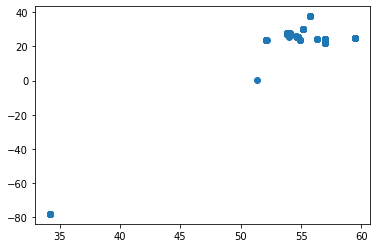

In [ ]:
plt.scatter(untappd['venue_lat'], untappd['venue_lng'])

#Spliting Data

In [ ]:
target = 'high_rating'
X = untappd.drop(columns=target)
X.drop(columns='rating_score', inplace=True)
y = untappd[target]

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_val, y_val, test_size=0.2, random_state=42)

# Baseline Accuracy

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.6227064220183486


# Modeling

In [ ]:
model_log = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)
model_log.fit(X_train, y_train);

In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_estimators=150)
)
model_rf.fit(X_train, y_train);

In [ ]:
model_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42, n_estimators=150)
)
model_gb.fit(X_train, y_train);

# Communicating Results

In [ ]:
print('Logistic Regression Training ACC:', model_log.score(X_train, y_train))
print('Logistic Regression Validation ACC:', model_log.score(X_val, y_val))

Logistic Regression Training ACC: 0.6668577981651376
Logistic Regression Validation ACC: 0.6750572082379863


In [ ]:
print('Random Forest Regression Training ACC:', model_rf.score(X_train, y_train))
print('Random Forest Regression Training ACC:', model_rf.score(X_val, y_val))

Random Forest Regression Training ACC: 0.9942660550458715
Random Forest Regression Training ACC: 0.7482837528604119


In [ ]:
print('Gradient Boosting Regression Training ACC:', model_gb.score(X_train, y_train))
print('Gradient Boosting Regression Training ACC:', model_gb.score(X_val, y_val))

Gradient Boosting Regression Training ACC: 0.8503440366972477
Gradient Boosting Regression Training ACC: 0.7620137299771167


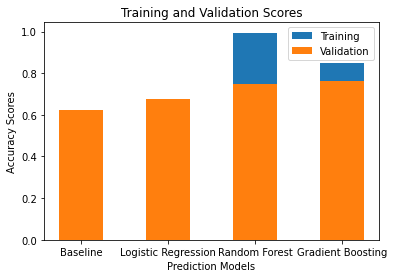

In [ ]:
training_scores = [baseline_acc, model_log.score(X_train, y_train), model_rf.score(X_train, y_train), model_gb.score(X_train, y_train)]
validation_scores = [baseline_acc, model_log.score(X_val, y_val), model_rf.score(X_val, y_val), model_gb.score(X_val, y_val)]
models = ['Baseline', 'Logistic Regression', 'Random Forest', 'Gradient Boosting']

ind=np.arange(4)
width = 0.5


plt.bar(models, training_scores, width)
plt.bar(models, validation_scores, width)
plt.legend(labels=['Training', 'Validation'])
plt.xlabel('Prediction Models')
plt.ylabel('Accuracy Scores')
plt.title('Training and Validation Scores');

# Gradient Boosting After Tuning

In [ ]:
model_gb_at = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(
        criterion='mse',
        learning_rate=0.2,
        loss='deviance',
        n_estimators=170
    )
)
model_gb_at.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:475: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: C

In [ ]:
print('Gradient Boosting Regression Training ACC after tuning:', model_gb_at.score(X_train, y_train))
print('Gradient Boosting Regression Validation ACC after tuning:', model_gb_at.score(X_val, y_val))

Gradient Boosting Regression Training ACC after tuning: 0.9162844036697247
Gradient Boosting Regression Validation ACC after tuning: 0.7734553775743707


Text(0.5, 0, 'Gini Importances')

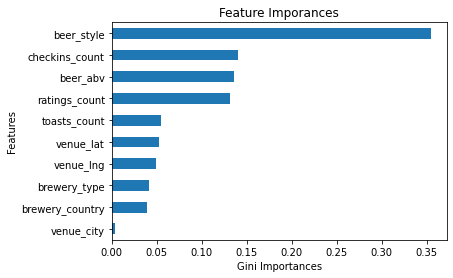

In [ ]:
importances = model_gb_at.named_steps['gradientboostingclassifier'].feature_importances_
features = X_val.columns
feat_imp = pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh')
plt.title('Feature Imporances')
plt.ylabel('Features')
plt.xlabel('Gini Importances')

In [ ]:
print('Gradient Boosting Classifier Testing Accuracy:', model_gb_at.score(X_test, y_test))

Gradient Boosting Classifier Testing Accuracy: 0.7527472527472527
